<a href="https://colab.research.google.com/github/juliaskrovan/dotfiles/blob/master/8-FaultDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/UT-GEOML/GEO391/blob/main/8-FaultDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

In image analysis, *segmentation* refers to the problem of dividing the input image into non-overlapping regions corresponding to different components.

![](https://ars.els-cdn.com/content/image/1-s2.0-S0264817220303019-gr10.jpg)

* Tang, D.G., Milliken, K.L. and Spikes, K.T., 2020. [Machine learning for point counting and segmentation of arenite in thin section](https://www.sciencedirect.com/science/article/pii/S0264817220303019). Marine and Petroleum Geology, 120, p.104518.

## Seismic fault detection

In seismic interpretation, segmentation may refer to picking horizons, lithofacies, geobodies, uncomformities, and faults. Today we will focus on the latter problem. The problem of automatic fault detection has a long history in seismic interpretation studies. Previous attempts focused on generating discontinuity attributes for assisting the interpreter in fault picking.

![](https://library.seg.org/cms/10.1190/INT-2015-0030.1/asset/images/medium/figure6.gif)
Karimi, P., Fomel, S., Wood, L. and Dunlap, D., 2015. [Predictive coherence](https://library.seg.org/doi/10.1190/INT-2015-0030.1). Interpretation, 3(4), pp.SAE1-SAE7.

Machine learning has enabled us to detect faults directly using an automatic segmentation approach.

![](https://library.seg.org/cms/10.1190/geo2018-0646.1/asset/images/medium/figure5.gif)
Wu, X., Liang, L., Shi, Y. and Fomel, S., 2019. [FaultSeg3D: Using synthetic data sets to train an end-to-end convolutional neural network for 3D seismic fault segmentation](https://library.seg.org/doi/full/10.1190/geo2018-0646.1). Geophysics, 84(3), pp.IM35-IM45.

Today we will be reproducing the work of Wu et al. (2019)

## Fault detection by image classification

The first attempt to detect faults (*FaultNet*) involved 2-D and 3-D image classifications analogous to 1-D waveform classification that we tried before. The idea was to classify a small patch extracted from a seismic image as either containing a fault (going through the middle of it) or no fault. Patches with faults were further subdivided into classes corresponding to dip and strike angles.

![](https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/36/8887423/8772081/wu4-2925003-small.gif)
![](https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/36/8887423/8772081/wu6-2925003-small.gif)
Wu, X., Shi, Y., Fomel, S., Liang, L., Zhang, Q. and Yusifov, A.Z., 2019. [FaultNet3D: Predicting fault probabilities, strikes, and dips with a single convolutional neural network](https://ieeexplore.ieee.org/abstract/document/8772081). IEEE Transactions on Geoscience and Remote Sensing, 57(11), pp.9138-9155.

The approach worked but was cumbersome and slow. A much more efficient approach is fault detection by image segmentation (*FaultSeg*).

## Generating data for training

Generating good data for training is the key for successful fault detection.

![](https://library.seg.org/cms/10.1190/geo2018-0646.1/asset/images/medium/figure1.gif)

The workflow starts with a horizontal reflectivity model that gets folded and faulted using parameterized functions with random parameters. The reflectivity model is then convolved with a Ricker wavelet to create a synthetic seismic image. Finally, some random noise is added to make the image look more realistic.

Let us look at some training data examples (2D for simplicity). The input data file <code>faults.npz</code> (about 200 MB) is available at https://drive.google.com/file/d/1sH7xY0pkmtha9B-4CJe6OcK4bC8ouVsp/view?usp=sharing

Using [Google Drive](https://drive.google.com/), you can create a shortcut for a shared file:
1. Right click the file.
2. Click **Add shortcut to Drive**.

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
import numpy as np

# loaded = np.load('/Users/sergey/Downloads/faults.npz')
loaded = np.load('/content/gdrive/My Drive/faults.npz')
data = loaded['data'] 
labels = loaded['labels']

print(data.shape, labels.shape)

(2000, 128, 128) (2000, 128, 128)


There are 2,000 two-dimensional training images with dimensions $128 \times 128$.

In [16]:
import matplotlib.pyplot as plt
import random


def plot_seismic(data, title):
    random.seed(2023)

    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6),
                            subplot_kw={'xticks': [], 'yticks': []})
    for ax in axs.flat:
        pick = random.randint(0, data.shape[0]-1)
        ax.imshow(data[pick, :, :], cmap='gray')
    plt.tight_layout()
    fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

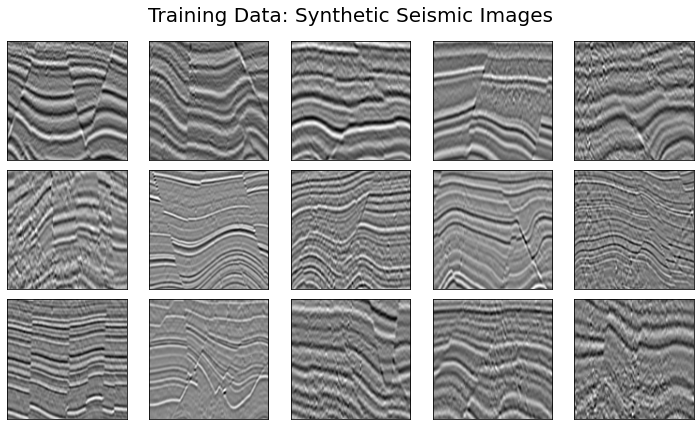

In [17]:
plot_seismic(data,'Training Data: Synthetic Seismic Images')

The images vary in reflection geometries, fault geometries, wavelet frequencies, and the amount of noise. 

In [18]:
def plot_faults(data, title):
    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6),
                            subplot_kw={'xticks': [], 'yticks': []})
    random.seed(2023)
    for ax in axs.flat:
        pick = random.randint(0, data.shape[0]-1)
        ax.imshow(data[pick, :, :], cmap='gray_r', interpolation='bilinear')
    plt.tight_layout()
    fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

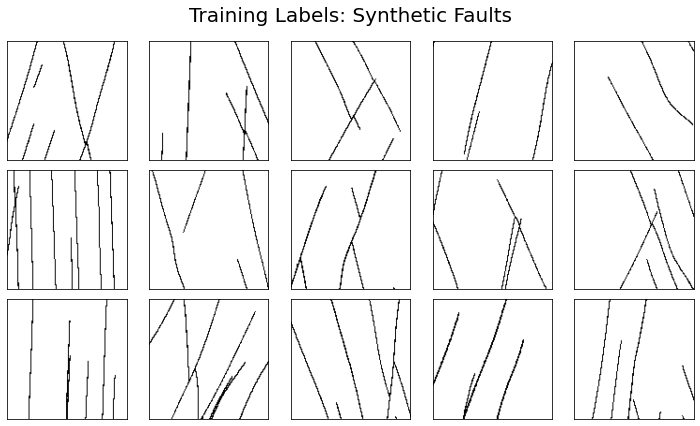

In [ ]:
plot_faults(labels, 'Training Labels: Synthetic Faults')

Because the images were synthetically generated, we know exactly where the faults are located and can use it for training.

In [19]:
def plot_seismic_faults(data, labels, title):
    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6),
                            subplot_kw={'xticks': [], 'yticks': []})
    random.seed(2022)
    for ax in axs.flat:
        pick = random.randint(0, data.shape[0]-1)
        ax.imshow(data[pick, :, :], cmap='gray')
        # overlay fault labels with alpha for transparency
        ax.imshow(labels[pick, :, :], cmap='gnuplot',
                  interpolation='none', alpha=0.4)
    plt.tight_layout()
    fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

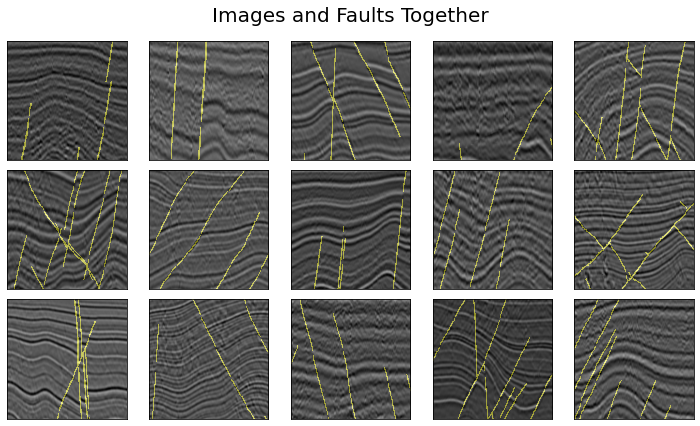

In [ ]:
plot_seismic_faults(data, labels, 'Images and Faults Together')

# Preparing data for training

To prepare the data for training, we will first normalize each image by subtracting the mean value and dividing by the standard deviation. After that, each image will have the mean of 0 and the standard deviation of 1. 

In [20]:
# normalize data
mean = data.mean(axis=(1, 2))[:, np.newaxis, np.newaxis]
std = data.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
data = (data-mean)/std

# add dimension of 1
data = np.expand_dims(data, axis=3)
data.shape

(2000, 128, 128, 1)

The fourth dimension of 1 is added to indicate that the input dataset has one channel.

As before, we will randomly split the data for training and validation.

In [21]:
from sklearn.model_selection import train_test_split

# Split the data for training and validation
data_train, data_valid, labels_train, labels_valid = \
    train_test_split(data, labels, test_size=0.2, shuffle=True)

# Designing a neural network

We are going to use a convolutional neural network (CNN) accelerated on GPUs.

When using Google Colab,  make sure that GPU acceletation is enabled:

1. Navigate to Edit→Notebook Settings in the top menu. 
2. Select GPU from the Hardware Accelerator drop-down menu.

In [22]:
from tensorflow import keras
from tensorflow.keras import layers


def Unet():
    keras.backend.clear_session()

    # can take arbitrary input size
    image = keras.Input((None, None, 1), name='input')

    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(image)
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)

    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(pool3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(conv4)

    up5 = layers.concatenate(
        [layers.UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.concatenate(
        [layers.UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.concatenate(
        [layers.UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)

    conv8 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = keras.Model(inputs=[image], outputs=[conv8])

    return model

In [ ]:
model = Unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input[0][0]']                  
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   2320        ['conv2d[0][0]']                 
                                16)                                                           

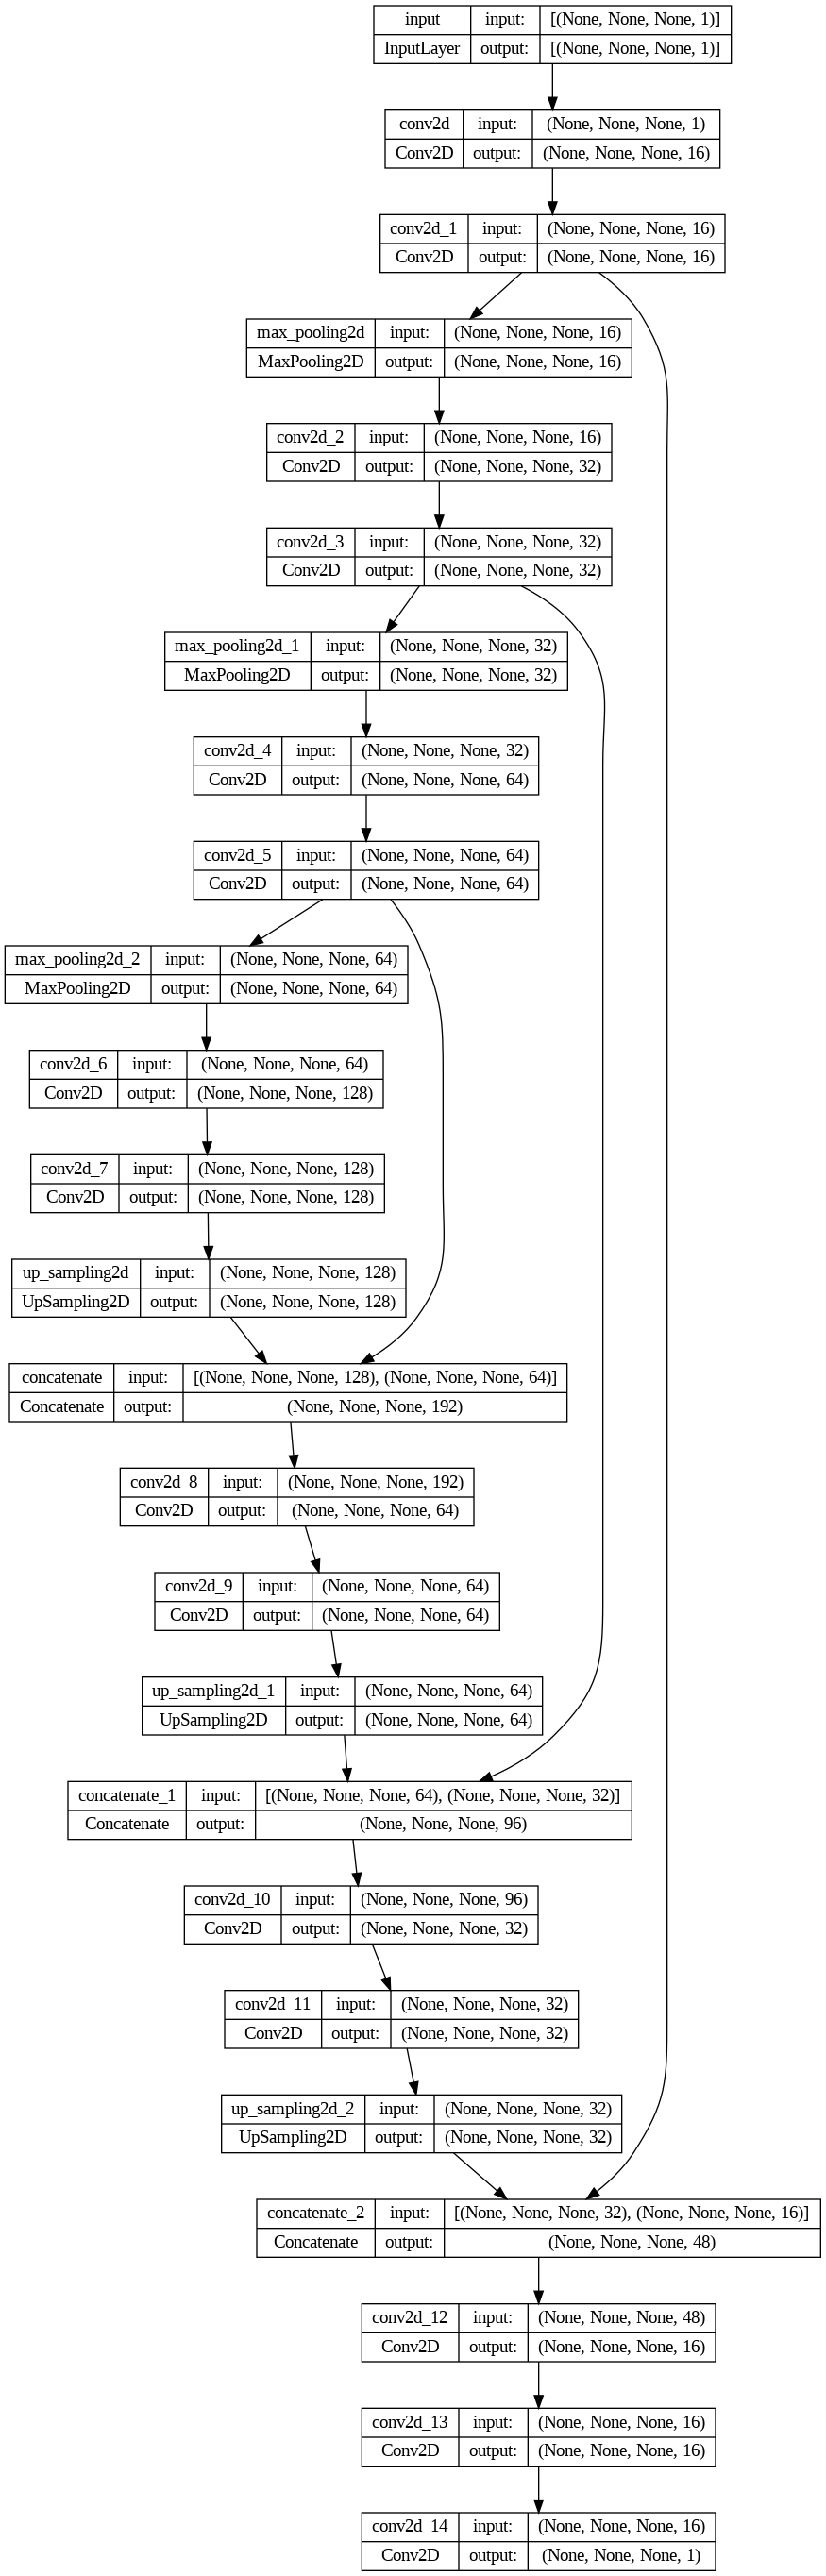

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

This type of model design is known as U-net (named after its shape) and was orginally developed for solving segmentation problems in biomedical imaging.

* Ronneberger, O., Fischer, P. and Brox, T., 2015. [U-net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

It proved successful in many other applications.

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-019-53797-9/MediaObjects/41598_2019_53797_Fig1_HTML.png)

* Kattenborn, T., Eichel, J. and Fassnacht, F.E., 2019. [Convolutional Neural Networks enable efficient, accurate and fine-grained segmentation of plant species and communities from high-resolution UAV imagery](https://www.nature.com/articles/s41598-019-53797-9). Scientific reports, 9(1), pp.1-9.

The compression of information by decreasing the image size on the left part of the **U** shape is analogous to the path in image classification and forces the network to extract the most essential patterns of the image. The original size is restored through convolutional steps on the right side of the **U**.

## Understanding 2-D convolution

Recall the 1-D convolution that we met before. In a matrix form, it can written as a special kind of a matrix:

$$\mathbf{C}_1 = \left[\begin{array}{ccccc}
f_1 & 0 & 0 & 0 & 0 \\
f_2 & f_1 & 0 & 0 & 0 \\
f_3 & f_2 & f_1 & 0 & 0 \\
f_4 & f_3 & f_2 & f_1 & 0 \\
0 & f_4 & f_3 & f_2 & f_1 \\
0 & 0 & f_4 & f_3 & f_2 \\
0 & 0 & 0 & f_4 & f_3 \\
0 & 0 & 0 & 0 & f_4
\end{array}\right]$$

The multiplication of an input vector $\mathbf{x}$ by the transpose of such a matrix

$$\mathbf{y} = \mathbf{C}^T\,\mathbf{x}$$

can be written in the component form as

$$y_k = \displaystyle \sum\limits_{n=1}^{N} f_n\,x_{k+n-1}$$

In the example above, $N=4$, and the output is smaller than the input by $N-1=3$.

What happens in the 2-D case? The filter acquires two indices instead of one, and the convolution operation is expressed as
$$y_{k_1,k_2} = \displaystyle \sum\limits_{n_1=1}^{N_1} \sum\limits_{n_2=1}^{N_2} f_{n_1,n_2}\,x_{k_1+n_1-1,k_2+n_2-1}$$

![](https://miro.medium.com/max/1400/1*o8O7owMwiF4Ull9NE-uWQw.gif)
https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148

Imagine a $3 \times 3$ input and a $2 \times 2$ filter. In the matrix form, the 2-D convolution can be written as

$$\scriptstyle \left[
\begin{array}{l}
y_{11} \\
y_{21} \\
\hline
y_{12} \\
y_{22} 
\end{array}
\right] = 
\left[
\begin{array}{rrr|rrr|rrr}
 f_{11} & f_{21} & 0  
& f_{12} & f_{22} & 0  
& 0  & 0  & 0  \\
 0 & f_{11} & f_{21} 
& 0  & f_{12}  & f_{22}  
& 0  & 0  & 0        \\
\hline
0  & 0  & 0  
& f_{11} & f_{21} & 0  
& f_{12} & f_{22} & 0 \\
0 & 0  & 0  
& 0 & f_{11} & f_{21}  
& 0  & f_{12}  & f_{22}    
\end{array}
\right]\,
\left[
\begin{array}{l}
x_{11} \\
x_{21} \\
x_{31} \\
\hline
x_{12} \\
x_{22} \\
x_{32} \\
\hline
x_{13} \\
x_{23} \\
x_{33} 
\end{array}
\right]$$

It retains the main properties of one-dimensional convolution, namely
1. reduction of the number of parameters,
2. reduction of the computational cost (particularly, when using GPU,)
3. translation invariance (now with respect to shifts in two dimensions.)

Understanding convolutions helps calculate the number of parameters. 

The first convolutional layer in our network goes from 1 to 16 channels using $3 \times 3$ filters. The number of parameters in this layer is $16 + 16 \times 3 \times 3 = 160$. 

The second layer goes from 16 to 16 channels. This requires $16 \times 16$ filters and 16 intercepts. The number of parameters is in this layer is $16 + 16 \times 16 \times 3 \times 3 = 2,320$.

If we tried to apply a dense (fully connected) layer instead on a $128 \times 128$ input, the number of parameters would have been $16 \times 128^2 + 16 \times 16 \times 128^2 \times 128^2$, approximately 30 million times more.

In [ ]:
16 + 16*16*3*3

2320

In [ ]:
(16*128*128+16*16*128*128*128*128)/2320

29620577.103448275

In [ ]:
layers.Conv2D?

## Maxpooling and upsampling

Max-pooling in 2D reduces both dimensions. For example, if the input is a $4 \times 4$ image

$$\left[\begin{array}{rrrr}
  0 & 1 & 2 & 3 \\
  4 & 5 & 6 & 7 \\
  8 & 9 & 10 & 11 \\
  12 & 13 & 14 & 15
\end{array}\right]\;,$$

max-pooling of size $2 \times 2$ is going to treat it as a $2 \times 2$ block

$$\left[\begin{array}{rr| rr}
  0 & 1 & 2 & 3 \\
  4 & 5 & 6 & 7 \\
  \hline
  8 & 9 & 10 & 11 \\
  12 & 13 & 14 & 15
\end{array}\right]$$

and reduce it to the $2 \times 2$ output by computing the maximum in each block:

$$\left[\begin{array}{rr}
  5 & 7 \\
  13 & 15 
\end{array}\right]$$

In [ ]:
x = np.array(list(range(16)))
x = np.reshape(x, [1, 4, 4, 1])
max_pool = layers.MaxPooling2D()
x = max_pool(x)
print(x)

tf.Tensor(
[[[[ 5]
   [ 7]]

  [[13]
   [15]]]], shape=(1, 2, 2, 1), dtype=int64)


Upsampling has the opposite effect of increasing the size. In the simplest application, the upsampling of a $2 \times 2$ image
$$\left[\begin{array}{rr}
  5 & 7 \\
  13 & 15 
\end{array}\right]$$

will replicate the entries to generate a $4 \times 4$ image

$$\left[\begin{array}{rr|rr}
  5 & 5 & 7 & 7 \\
  5 & 5 & 7 & 7 \\
  \hline
  13 & 13 & 15 & 15 \\
 13 & 13 & 15 & 15 
\end{array}\right]$$

In [ ]:
upsample = layers.UpSampling2D()
x = upsample(x)
print(x)

tf.Tensor(
[[[[ 5]
   [ 5]
   [ 7]
   [ 7]]

  [[ 5]
   [ 5]
   [ 7]
   [ 7]]

  [[13]
   [13]
   [15]
   [15]]

  [[13]
   [13]
   [15]
   [15]]]], shape=(1, 4, 4, 1), dtype=int64)


# Model training

Now we are ready to train our model. As before, we will use cross-entropy as the loss function (applied pixel-by-pixel in the image), and Adam as the optimization algorithm.

In [23]:
model = Unet()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
# Fit the model
batch_size = 16
epochs = 50
fit = model.fit(data_train, labels_train,
                validation_data=(data_valid, labels_valid),
                epochs=epochs,
                batch_size=batch_size)

Epoch 1/50
100/100 [==============================] - 19s 44ms/step - loss: 0.1759 - accuracy: 0.9614 - val_loss: 0.1475 - val_accuracy: 0.9656
Epoch 2/50
100/100 [==============================] - 4s 36ms/step - loss: 0.1379 - accuracy: 0.9662 - val_loss: 0.1230 - val_accuracy: 0.9656
Epoch 3/50
100/100 [==============================] - 4s 37ms/step - loss: 0.1120 - accuracy: 0.9663 - val_loss: 0.1063 - val_accuracy: 0.9668
Epoch 4/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0972 - accuracy: 0.9691 - val_loss: 0.0961 - val_accuracy: 0.9694
Epoch 5/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0887 - accuracy: 0.9711 - val_loss: 0.0905 - val_accuracy: 0.9707
Epoch 6/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0838 - accuracy: 0.9724 - val_loss: 0.0851 - val_accuracy: 0.9722
Epoch 7/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0797 - accuracy: 0.9734 - val_loss: 0.0825 - val_accuracy: 0.973

In [25]:
def plot_accuracy(history):
    fig = plt.figure(figsize=(16, 8))
    plt.plot(history['accuracy'], label='training')
    plt.plot(history['val_accuracy'], label='validation')
    plt.ylabel('Accuracy', fontsize=25)
    plt.xlabel('Epoch', fontsize=25)
    plt.legend(fontsize=25)
    plt.show()


def plot_loss(history):
    # summarize history for loss
    fig = plt.figure(figsize=(16, 8))
    plt.plot(history['loss'], label='training')
    plt.plot(history['val_loss'], label='validation')
    plt.ylabel('Loss', fontsize=25)
    plt.xlabel('Epoch', fontsize=25)
    plt.legend(fontsize=25)
    plt.show()

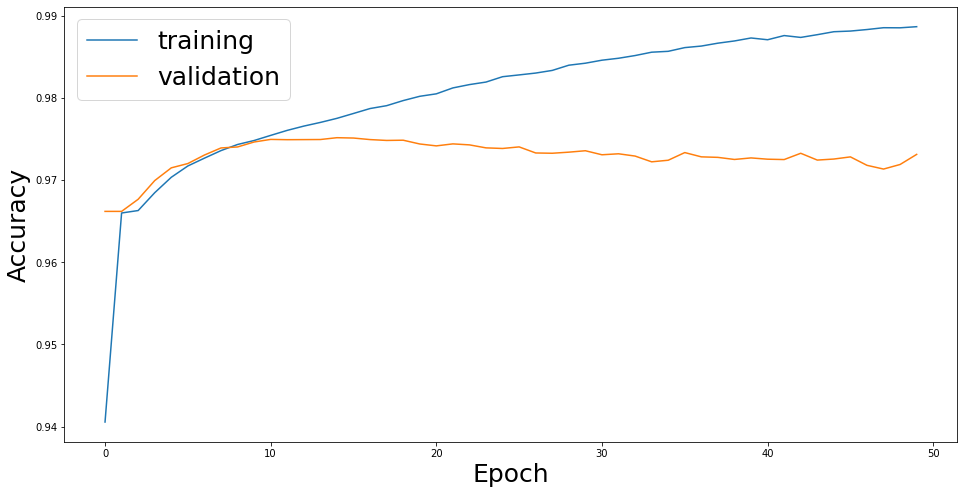

In [ ]:
plot_accuracy(fit.history)

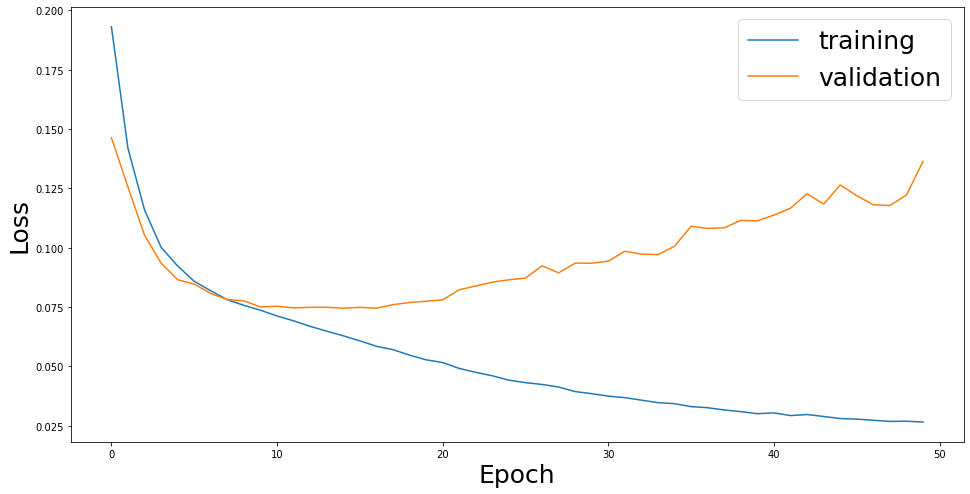

In [ ]:
plot_loss(fit.history)

## Using callbacks

We can see that, at later epochs, the model slides into overfitting.

We have learned different ways to deal with this problem before.

To avoid getting a worse model at the end that the one in the middle of iterations, we can ask the network to store the best model during iterations. An implementation of this idea in Keras involves a *callback* checkpoint function.

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max',
                             verbose=1, save_best_only=True)
callbacks = [checkpoint]

In [27]:
model = Unet()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Fit the model
batch_size = 16
epochs = 25
fit = model.fit(data_train, labels_train,
                validation_data=(data_valid, labels_valid),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9649
Epoch 1: val_accuracy improved from -inf to 0.96560, saving model to model.h5
100/100 [==============================] - 10s 51ms/step - loss: 0.1719 - accuracy: 0.9649 - val_loss: 0.1447 - val_accuracy: 0.9656
Epoch 2/25
 99/100 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9662
Epoch 2: val_accuracy improved from 0.96560 to 0.96560, saving model to model.h5
100/100 [==============================] - 4s 43ms/step - loss: 0.1282 - accuracy: 0.9662 - val_loss: 0.1147 - val_accuracy: 0.9656
Epoch 3/25
 99/100 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9672
Epoch 3: val_accuracy improved from 0.96560 to 0.96876, saving model to model.h5
100/100 [==============================] - 4s 39ms/step - loss: 0.1051 - accuracy: 0.9672 - val_loss: 0.0995 - val_accuracy: 0.9688
Epoch 4/25
 99/100 [============================>.] - ETA: 0s - loss: 0.092

In [28]:
# load the best model
model = Unet()
model.load_weights('model.h5')
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Checking results

In [29]:
prediction = model.predict(data_valid)

# thresholding probability
labels_pred = prediction
labels_pred[prediction >= 0.5] = 1
labels_pred[prediction < 0.5] = 0

13/13 [==============================] - 1s 15ms/step


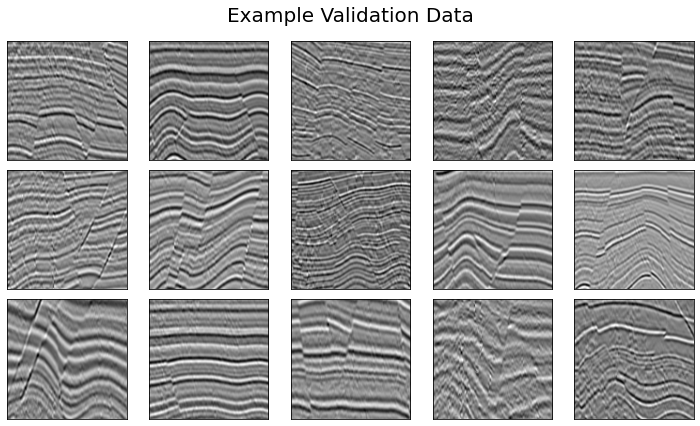

In [ ]:
plot_seismic(data_valid[:, :, :, 0], 'Example Validation Data')

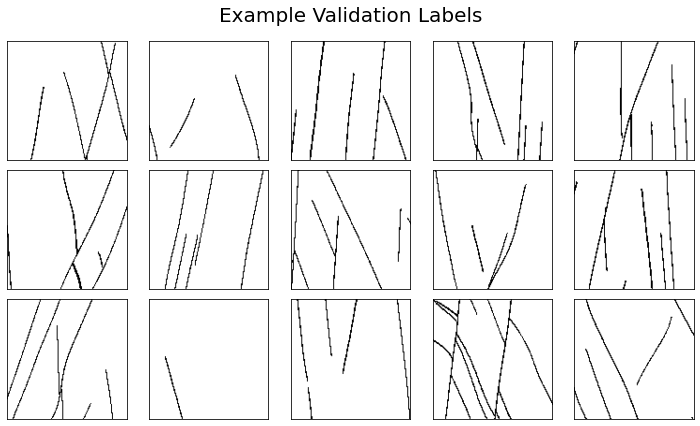

In [ ]:
plot_faults(labels_valid, 'Example Validation Labels')

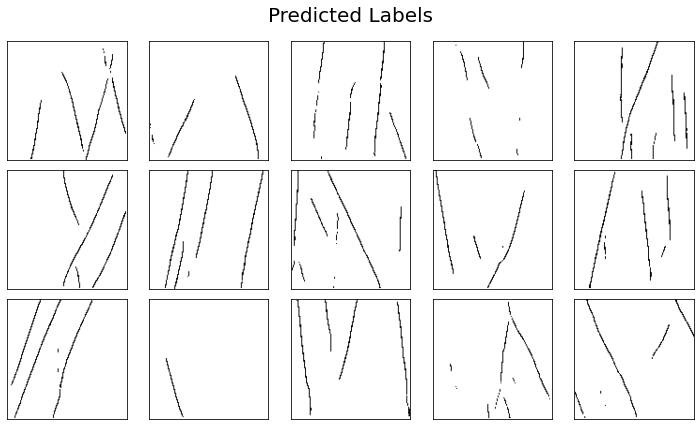

In [ ]:
plot_faults(labels_pred[:, :, :, 0], 'Predicted Labels')

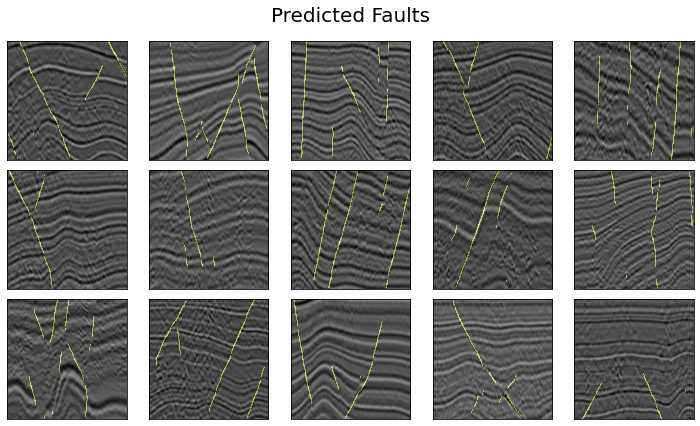

In [ ]:
plot_seismic_faults(data_valid[:, :, :, 0],
                    labels_pred[:, :, :, 0], 'Predicted Faults')

# Testing on real data

So far, we only tried our model on synthetic data. Let us apply it now on a real seismic image (a portion of a dataset from New Zealand).

In [30]:
image = loaded['test']
image.shape

(100, 256, 640)

In [31]:
imean = image.mean(axis=(1, 2))[:, np.newaxis, np.newaxis]
istd = image.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
image1 = (image-imean)/istd

# add dimension of 1
image = np.expand_dims(image, axis=3)

In [32]:
fault_probability = model.predict(image)
faults = fault_probability
faults[faults >= 0.4] = 1
faults[faults < 0.4] = 0

4/4 [==============================] - 4s 382ms/step


In [33]:
def plot_image(line):
    plt.figure(figsize=(15, 10))
    plt.imshow(image[line, :, :, 0], cmap='gray')
    plt.imshow(faults[line, :, :, 0], cmap='gnuplot',
               interpolation='none', alpha=0.4)
    plt.title('Slice {}'.format(line), fontsize=25)
    plt.show()

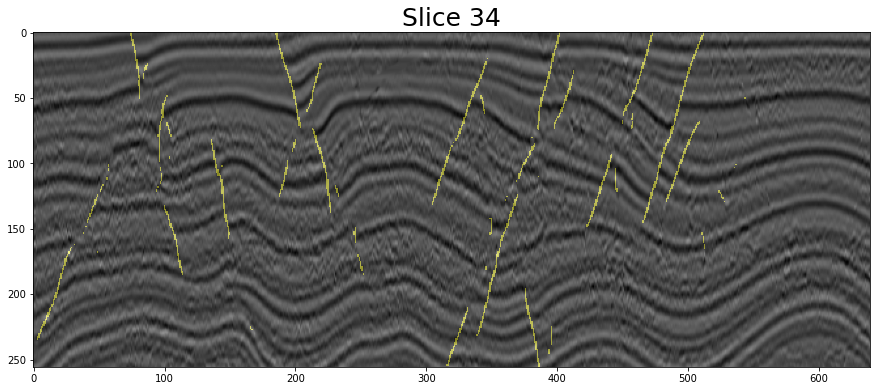

In [ ]:
plot_image(34)

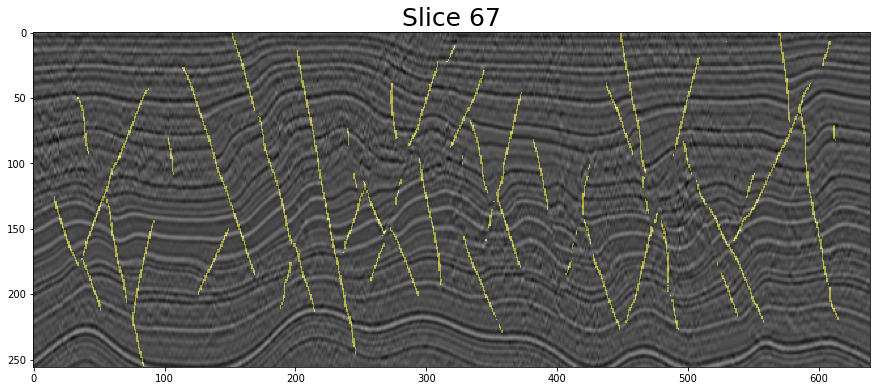

In [ ]:
plot_image(67)

## Looking inside the black box

Although it is hard to figure out the exact internal deliberations of the neural network, we can try to take it apart to look inside.

First, let us visualize some of the convolutional filters.

In [ ]:
# check for convolutional layers
for num, layer in enumerate(model.layers):
    # check for convolutional layers
    if 'conv' in layer.name:
        # get filter weights
        filters, biases = layer.get_weights()
        print(num, ':', layer.name, filters.shape)

1 : conv2d (3, 3, 1, 16)
2 : conv2d_1 (3, 3, 16, 16)
4 : conv2d_2 (3, 3, 16, 32)
5 : conv2d_3 (3, 3, 32, 32)
7 : conv2d_4 (3, 3, 32, 64)
8 : conv2d_5 (3, 3, 64, 64)
10 : conv2d_6 (3, 3, 64, 128)
11 : conv2d_7 (3, 3, 128, 128)
14 : conv2d_8 (3, 3, 192, 64)
15 : conv2d_9 (3, 3, 64, 64)
18 : conv2d_10 (3, 3, 96, 32)
19 : conv2d_11 (3, 3, 32, 32)
22 : conv2d_12 (3, 3, 48, 16)
23 : conv2d_13 (3, 3, 16, 16)
24 : conv2d_14 (1, 1, 16, 1)


We can check what kind of filters the network applies in the first convolutional layer.

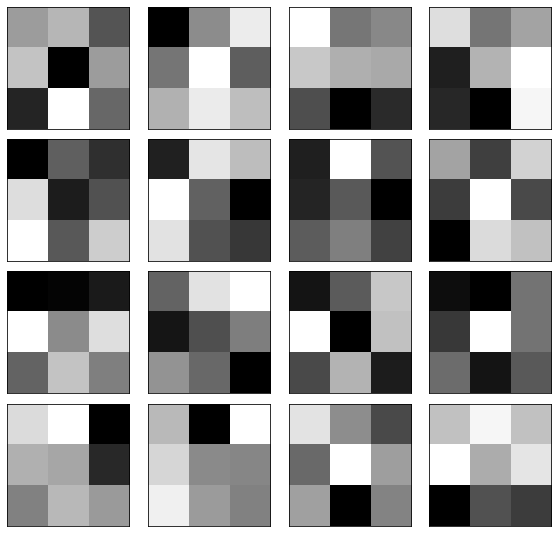

In [34]:
filters, biases = model.layers[1].get_weights()
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for k, ax in enumerate(axs.flat):
    ax.imshow(filters[:, :, 0, k], interpolation='none', cmap='gray')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

It looks like the filters have directionality and try to remove low-frequency components from the data, because low-frequency components don't contribute to fault detection.

We can check to see what these filters do to the data.

In [ ]:
partial_model = keras.Model(inputs=model.inputs,
                            outputs=model.layers[1].output)
features = partial_model.predict(image1)
features.shape

4/4 [==============================] - 0s 29ms/step


(100, 256, 640, 16)

In [ ]:
def show_feature(k):
    plt.figure(figsize=(15, 12))
    plt.imshow(features[67, :, :, k-1], cmap='gray')
    plt.title('Slice 67, Feature {}'.format(k), fontsize=20)
    plt.show()

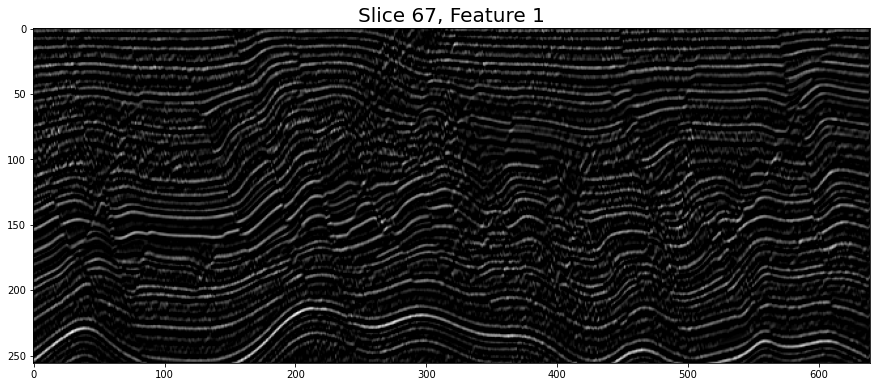

In [ ]:
show_feature(1)

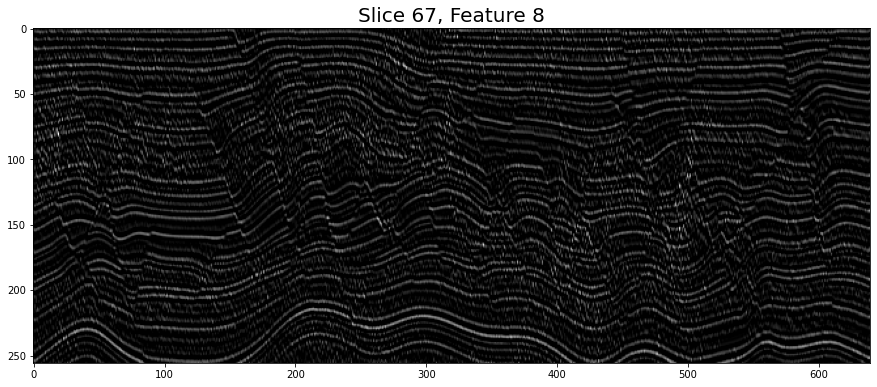

In [ ]:
show_feature(8)

## <div style="color:red">Task 1</div>

Plot selected filters and features from another layer of the neural network. 

Can you try to explain what you see?

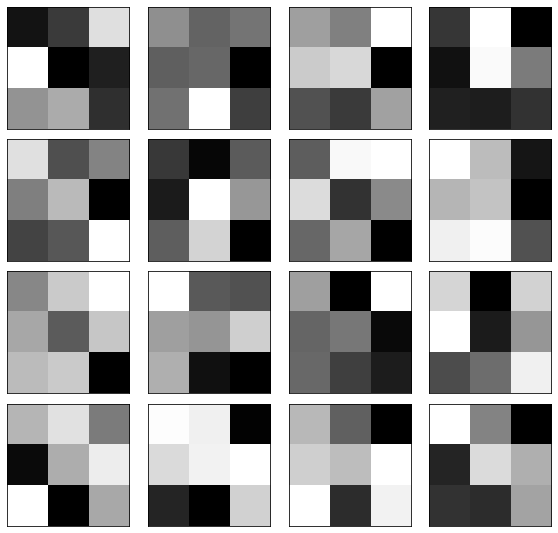

In [ ]:
filters, biases = model.layers[23].get_weights()
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for k, ax in enumerate(axs.flat):
    ax.imshow(filters[:, :, 0, k], interpolation='none', cmap='gray')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
partial_model_2 = keras.Model(inputs=model.inputs,
                            outputs=model.layers[23].output)
features_2 = partial_model_2.predict(image1)
features_2.shape

4/4 [==============================] - 1s 144ms/step


(100, 256, 640, 16)

In [ ]:
def show_feature_2(k):
    plt.figure(figsize=(15, 12))
    plt.imshow(features_2[67, :, :, k-1], cmap='gray')
    plt.title('Slice 67, Feature {}'.format(k), fontsize=20)
    plt.show()

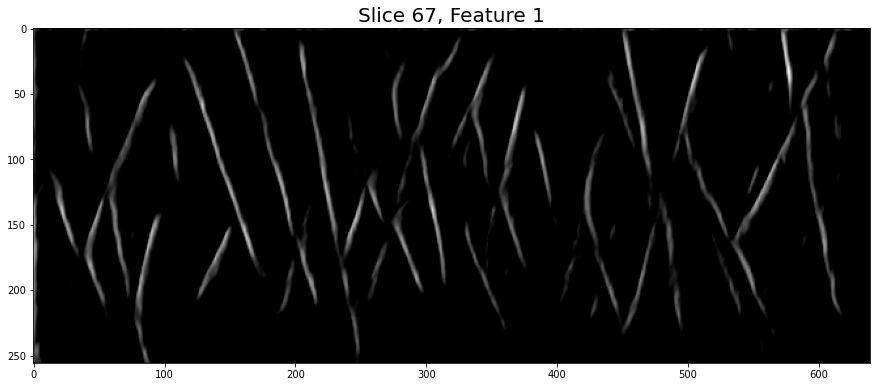

In [ ]:
show_feature_2(1)

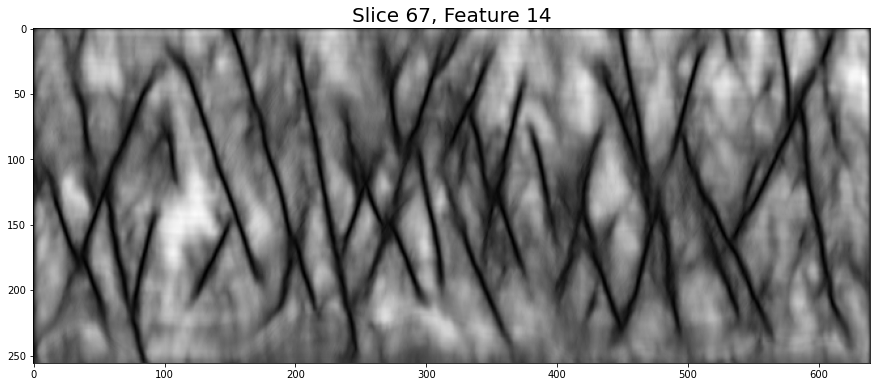

In [ ]:
show_feature_2(14)

We selected 23rd layer to acquire the filter maps. Since we are displaying the filter map from the final layer of the model, the model has already done work to identify the faults.

Filter 1 highligts faults while Filter 14 removes faults and highlights "blobs" in the vicinity of faults.

In the filters diagram, filter 1 and 14 display polarity. The same shape with opposite values.

## <div style="color:red">Task 2</div>

In this task, try to improve the accuracy of the network using one of the following methods:

1. Add more data for training. In the process known as *image augmentation*, the images and corresponding labels can be perturbed by a variety of geometric transformations to generate more data for training and better predictions.

See https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 

A simple example in our case would be horizontal flipping. By adding flipped images and flipped labels to the dataset, we could easily increase the number of training images by two.

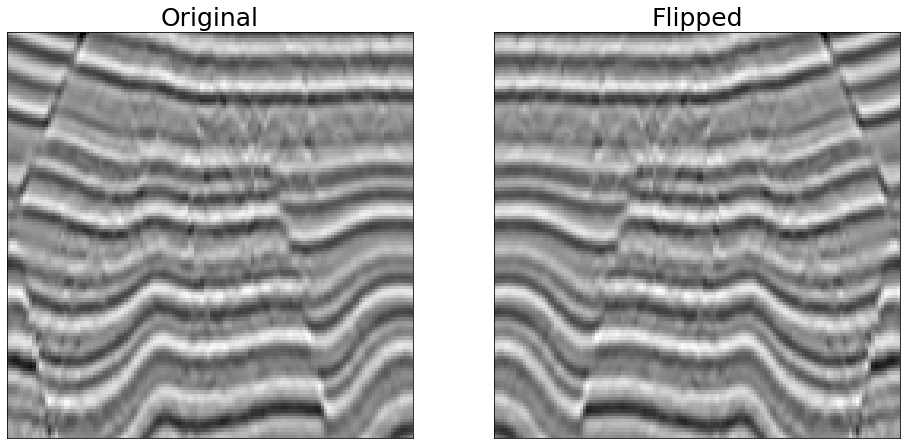

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
image1 = data[1000, :, :, 0]
axs[0].imshow(image1, cmap='gray')
axs[0].set_title('Original', fontsize=25)
image2 = np.flip(image1, axis=1)
axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Flipped', fontsize=25)
plt.show()

In [36]:
# create empty arrays for regular + flipped images and labels
data_flip = np.zeros([4000, 128, 128, 1])
labels_flip = np.zeros([4000, 128, 128])

In [37]:
# flip images (data) and labels
for i in range(len(data)):
  data_flip[i,:,:,:] = data[i,:,:,:]
  data_flip[i+2000,:,:,:] = np.flip(data[i,:,:,:], axis=1)
  labels_flip[i,:,:] = labels[i,:,:]
  labels_flip[i+2000,:,:] = np.flip(labels[i,:,:], axis=1)

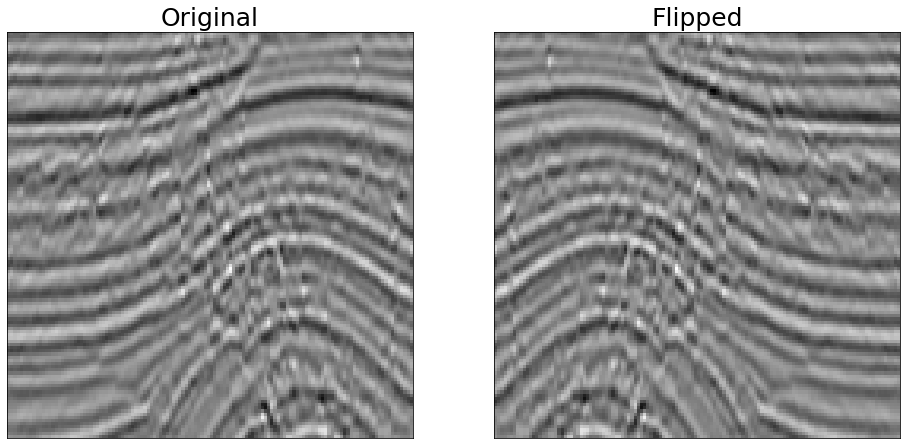

In [38]:
# plot example to check flipped data
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
image1 = data_flip[2, :, :]
axs[0].imshow(image1, cmap='gray')
axs[0].set_title('Original', fontsize=25)
image2 = data_flip[2002, :, :]
axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Flipped', fontsize=25)
plt.show()

In [39]:
from sklearn.model_selection import train_test_split

# Split the data for training and validation
data_flip_train, data_flip_valid, labels_flip_train, labels_flip_valid = \
    train_test_split(data_flip, labels_flip, test_size=0.2, shuffle=True)

In [40]:
# Fit the original model using the flipped data
batch_size = 16
epochs = 25
fit_1 = model.fit(data_flip_train, labels_flip_train,
                validation_data=(data_flip_valid, labels_flip_valid),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/25
200/200 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9760
Epoch 1: val_accuracy improved from 0.97500 to 0.97619, saving model to model.h5
200/200 [==============================] - 14s 41ms/step - loss: 0.0711 - accuracy: 0.9760 - val_loss: 0.0701 - val_accuracy: 0.9762
Epoch 2/25
199/200 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9769
Epoch 2: val_accuracy improved from 0.97619 to 0.97631, saving model to model.h5
200/200 [==============================] - 8s 39ms/step - loss: 0.0665 - accuracy: 0.9769 - val_loss: 0.0690 - val_accuracy: 0.9763
Epoch 3/25
199/200 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9775
Epoch 3: val_accuracy improved from 0.97631 to 0.97657, saving model to model.h5
200/200 [==============================] - 8s 38ms/step - loss: 0.0644 - accuracy: 0.9775 - val_loss: 0.0684 - val_accuracy: 0.9766
Epoch 4/25
199/200 [============================>.] - ETA: 0s - loss: 0.

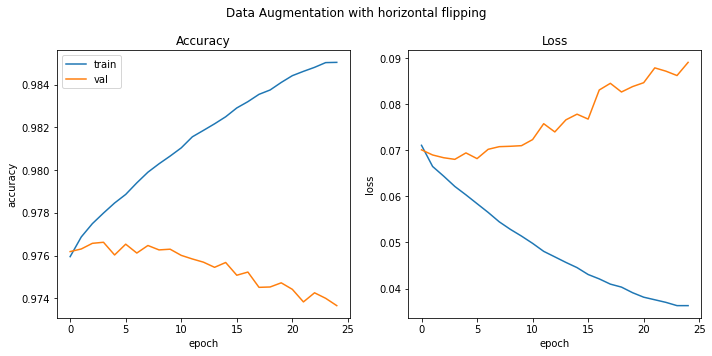

In [41]:
plt.figure(figsize=(10,5), tight_layout=True)

# Plot validation and loss With flipped data augmentation
plt.suptitle('Data Augmentation with horizontal flipping')
plt.subplot(1, 2, 1)
plt.plot(fit_1.history['accuracy'])
plt.plot(fit_1.history['val_accuracy'])
plt.title('Accuracy', fontsize=12)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(fit_1.history['loss'])
plt.plot(fit_1.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch');

2. Use *batch normalization*.

Batch normalization renormalizes images during an application of the neural network. You can implement it in **Keras** by changing lines like
```python
conv1 = layers.Conv2D(16, (3,3), activation='relu', 
                      padding='same')(conv1)
```

to 
```python
conv1 = layers.Conv2D(16, (3,3), padding='same')(conv1)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation('relu')(conv1)
```

It may help to rewrite the function <code>Unet()</code> to put repeatable blocks of code into separate functions. 

In [ ]:
layers.BatchNormalization?

In [49]:
from tensorflow import keras
from tensorflow.keras import layers

def Unet_2():
    keras.backend.clear_session()

    # can take arbitrary input size
    image = keras.Input((None, None, 1), name='input')

    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(image)
    conv1 = layers.Conv2D(16, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)

    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(pool3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(conv4)

    up5 = layers.concatenate(
        [layers.UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.concatenate(
        [layers.UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.concatenate(
        [layers.UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)

    conv8 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = keras.Model(inputs=[image], outputs=[conv8])

    return model

In [45]:
model_2 = Unet_2()
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input[0][0]']                  
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   2320        ['conv2d[0][0]']                 
                                16)                                                           

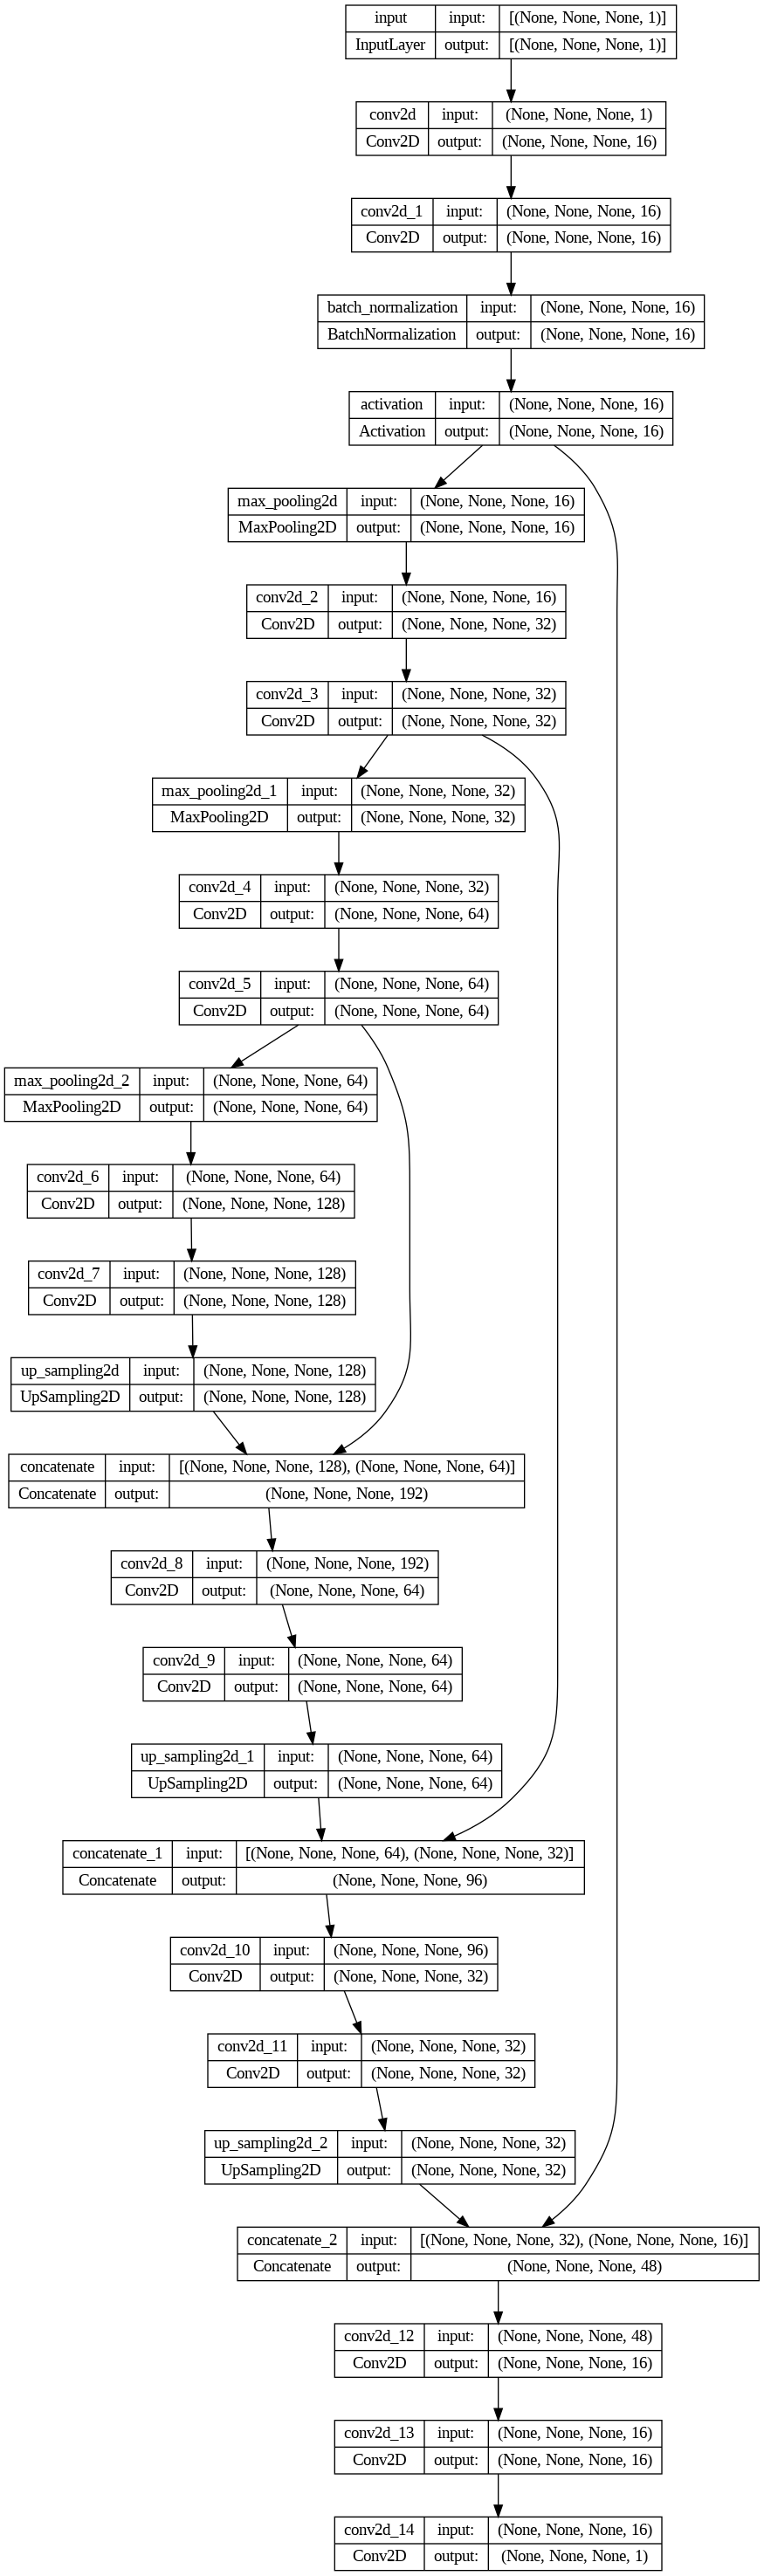

In [ ]:
keras.utils.plot_model(model_2, show_shapes=True)

In [71]:
checkpoint_2 = ModelCheckpoint('model_2.h5', monitor='val_accuracy', mode='max',
                             verbose=1, save_best_only=True)
callbacks_2 = [checkpoint_2]

In [72]:
model_2 = Unet_2()
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [73]:
# Fit the model
batch_size = 16
epochs = 50
fit_2 = model_2.fit(data_flip_train, labels_flip_train,
                validation_data=(data_flip_valid, labels_flip_valid),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks_2)

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9645
Epoch 1: val_accuracy improved from -inf to 0.96541, saving model to model_2.h5
200/200 [==============================] - 14s 43ms/step - loss: 0.1435 - accuracy: 0.9645 - val_loss: 0.1802 - val_accuracy: 0.9654
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9685
Epoch 2: val_accuracy improved from 0.96541 to 0.97053, saving model to model_2.h5
200/200 [==============================] - 9s 47ms/step - loss: 0.1013 - accuracy: 0.9685 - val_loss: 0.0924 - val_accuracy: 0.9705
Epoch 3/50
199/200 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9723
Epoch 3: val_accuracy improved from 0.97053 to 0.97328, saving model to model_2.h5
200/200 [==============================] - 8s 42ms/step - loss: 0.0843 - accuracy: 0.9723 - val_loss: 0.0800 - val_accuracy: 0.9733
Epoch 4/50
199/200 [============================>.] - ETA: 0s - loss:

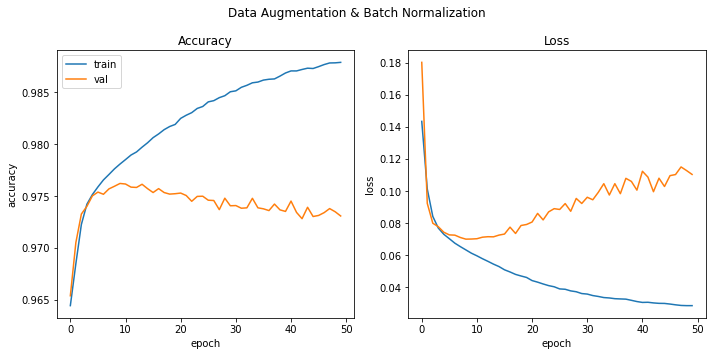

In [74]:
plt.figure(figsize=(10,5), tight_layout=True)

# With flipped data augmentation & batch normalization
plt.suptitle('Data Augmentation & Batch Normalization')
plt.subplot(1, 2, 1)
plt.plot(fit_2.history['accuracy'])
plt.plot(fit_2.history['val_accuracy'])
plt.title('Accuracy', fontsize=12)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(fit_2.history['loss'])
plt.plot(fit_2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch');

In [75]:
model_2 = Unet_2()
model_2.load_weights('model_2.h5')
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

3. Use transposed convolution instead of <code>layers.UpSampling2D()</code> for a better control of upsampling on the right side of the network. 

You can implement it in **Keras** by changing lines like

```python
up5 = layers.concatenate(
    [layers.UpSampling2D(size=(2, 2))(conv4), conv3], 
    axis=-1)
```

to

```python
up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2,2),
                             padding='same')(conv4)
up5 = layers.concatenate([up5, conv3], axis=-1)
```

In [ ]:
layers.Conv2DTranspose?

In [ ]:
type(data)

numpy.ndarray

In [ ]:
data.shape

(2000, 128, 128, 1)

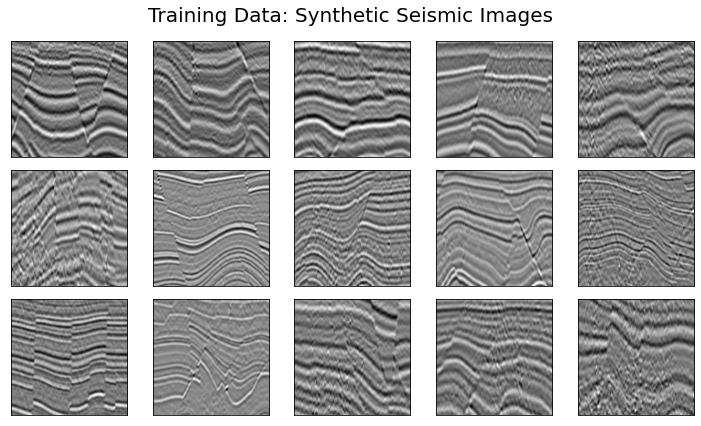

In [ ]:
plot_seismic(data,'Training Data: Synthetic Seismic Images')

## <div style="color:red">Task 3</div>

Apply fault detection to the previously interpreted dataset and plot the results.

The input data (341 MB) is available at https://drive.google.com/file/d/1UhK9kSjgGdY9K85wGXg5bFVRu_nw133X/view?usp=sharing

Using [Google Drive](https://drive.google.com/), you can create a shortcut for a shared file:
1. Right click the file.
2. Click **Add shortcut to Drive**.

In [9]:
pip install segpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from segpy.reader import create_reader

# A smaller portion of seismic data
# filename = '/Users/sergey/Downloads/faults.sgy'
filename = '/content/gdrive/My Drive/faults.sgy'
segy = open(filename, 'rb')
reader = create_reader(segy)
print(reader.num_traces())
# should output 130221

INFO:segpy.reader:Successfully unpickled reader for /content/gdrive/My Drive/faults.sgy


130221


In [12]:
import numpy as np

# get cube dimensions
nt = reader.max_num_trace_samples()  # samples in a trace
n_inlines = reader.num_inlines()  # number of inlines
n_xlines = reader.num_xlines()  # number of crosslines
print(nt, n_inlines, n_xlines)

cube = np.zeros((nt, n_xlines, n_inlines))

for j in range(n_inlines):
    print(j, end='\r')
    for i in range(n_xlines):
        cube[:, i, j] = reader.trace_samples(j*n_xlines + i)

cube.shape

626 351 371


(626, 371, 351)

In [13]:
cube_mean = cube.mean(axis=(1, 2))[:, np.newaxis, np.newaxis]
cube_std = cube.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
cube_normal = (cube-cube_mean)/(cube_std+1e-6)

cube_t = np.expand_dims(np.transpose(
    cube_normal[:624, :368, :], [2, 0, 1]), axis=3)
cube_t.shape

(351, 624, 368, 1)

In [76]:
prediction_cube = model_2.predict(cube_t)

# thresholding probability
labels_pred_cube = prediction_cube
labels_pred_cube[prediction_cube >= 0.5] = 1
labels_pred_cube[prediction_cube < 0.5] = 0

11/11 [==============================] - 3s 245ms/step


In [59]:
def plot_image_cube(line):
    plt.figure(figsize=(15, 10))
    plt.imshow(cube_t[line, :, :, 0], cmap='gray')
    plt.imshow(labels_pred_cube[line, :, :, 0], cmap='gnuplot',
               interpolation='none', alpha=0.4)
    plt.title('Slice {}'.format(line), fontsize=25)
    plt.show()

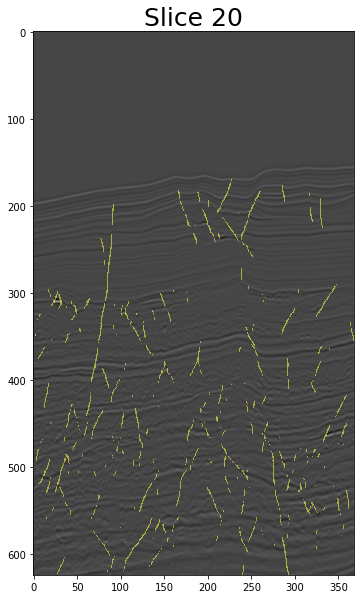

In [77]:
plot_image_cube(20)

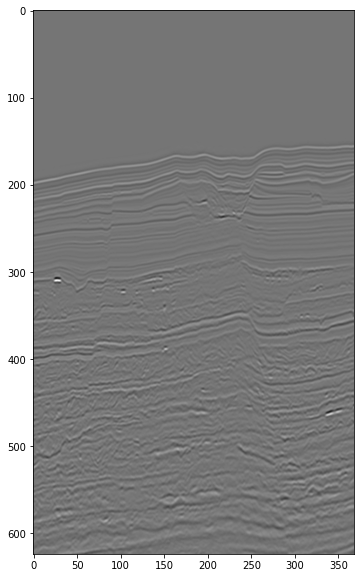

In [80]:
from matplotlib import pyplot as plt

plt.figure(figsize = (6,10))
plt.imshow(cube_t[20, :, :, 0], cmap='gray');

## Applying pretrained 3D model

We can also try a pretrained 3D fault-detection model provided by Xinming Wu: https://drive.google.com/drive/folders/1q8sAoLJgbhYHRubzyqMi9KkTeZWXWtNd

Using [Google Drive](https://drive.google.com/), you can create a shortcut for a shared file:
1. Right click the file.
2. Click **Add shortcut to Drive**.

In [81]:
import tensorflow as tf


def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x


def cross_entropy_balanced(y_true, y_pred):
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits,
    # Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred = tf.log(y_pred / (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(
        logits=y_pred, targets=y_true, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)

In [84]:
xinming_model = keras.models.load_model('/content/gdrive/My Drive/fseg-60.hdf5',
                                        custom_objects={'cross_entropy_balanced':
                                                        cross_entropy_balanced})

In [85]:
xinming_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d_1 (Conv3D)              (None, None, None,   448         ['input_1[0][0]']                
                                None, 16)                                                         
                                                                                                  
 conv3d_2 (Conv3D)              (None, None, None,   6928        ['conv3d_1[0][0]']               
                                None, 16)                                                   

In [89]:
cube_t.shape

(351, 624, 368, 1)

In [118]:
# adjusted dimensions of cube data for
cube_3D = np.expand_dims(cube_t, axis=0)
cube_3D.shape

(1, 351, 624, 368, 1)

In [119]:
cube_3D = cube_3D[:,:256,256:512,:256,:]
cube_3D.shape

(1, 256, 256, 256, 1)

In [120]:
prediction_3D = xinming_model.predict(cube_3D)


1/1 [==============================] - 0s 104ms/step


In [121]:
def plot_image_3D(line):
    plt.figure(figsize=(15, 10))
    plt.imshow(cube_3D[0, line, :, :, 0], cmap='gray')
    plt.imshow(labels_pred_3D[0, line, :, :, 0], cmap='gnuplot',
               interpolation='none', alpha=0.4)
    plt.title('Slice {}'.format(line), fontsize=25)
    plt.show()

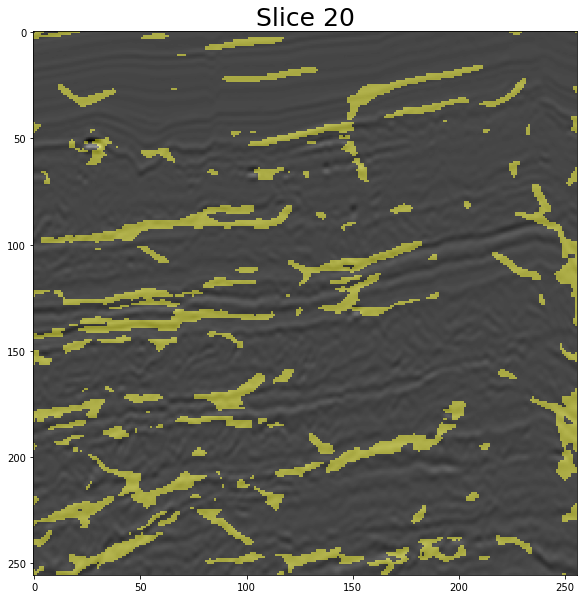

In [124]:
plot_image_3D(20)

This does not seem right to us. Perhaps with more information about the model construction, we could re-evaluate the approach and check whether we are applying it incorrectly to the data.

## <span style="color:red">Task 4</span>

In the table below, briefly describe your plan for the class project

      
| Element             | Description |
|:--------------------|-------------|
| 1. Problem to solve |  NMO Velocity Analysis Automation           |
| 2. Data to use      |      SEG Open Prestack Seismic Data       |
| 3. Methods to apply |       CNN      |